In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
 
file_path = 'Star_6_class.csv'
df = pd.read_csv(file_path)

df['Star color'] = LabelEncoder().fit_transform(df['Star color'])
df['Spectral Class'] = LabelEncoder().fit_transform(df['Spectral Class'])
 
X = df.drop(columns=['Star type'])  
y = df['Star type'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

input_size = X_train.shape[1]  
hidden_size = 32                 
num_hidden_layers = 3          
output_size = len(np.unique(y_train))  
epochs = 500                    
learning_rate = 0.01            

def initialize_weights(input_size, hidden_size, output_size, num_hidden_layers):
    np.random.seed(42)  
    weights = {}

    for i in range(1, num_hidden_layers + 1):
        if i == 1:
            weights[f'W{i}'] = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        else:
            weights[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size)
        weights[f'b{i}'] = np.zeros((1, hidden_size))

    weights[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
    weights[f'b{num_hidden_layers + 1}'] = np.zeros((1, output_size))

    return weights

weights = initialize_weights(input_size, hidden_size, output_size, num_hidden_layers)
 
def forward_propagation(X, weights, num_hidden_layers):
    activations = {}
    A = X
    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, weights[f'W{i}']) + weights[f'b{i}']
        A = np.maximum(0, Z) 
        activations[f'Z{i}'] = Z
        activations[f'A{i}'] = A

    Z_out = np.dot(A, weights[f'W{num_hidden_layers + 1}']) + weights[f'b{num_hidden_layers + 1}']
    A_out = softmax(Z_out)  
    activations[f'Z{num_hidden_layers + 1}'] = Z_out
    activations[f'A{num_hidden_layers + 1}'] = A_out

    return activations

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # For numerical stability
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
 
def backward_propagation(X, y, weights, activations, num_hidden_layers):
    gradients = {}
    m = y.shape[0]
    y_onehot = np.zeros((m, output_size))
    y_onehot[np.arange(m), y] = 1
 
    dZ = activations[f'A{num_hidden_layers + 1}'] - y_onehot
    gradients[f'dW{num_hidden_layers + 1}'] = (1 / m) * np.dot(activations[f'A{num_hidden_layers}'].T, dZ)
    gradients[f'db{num_hidden_layers + 1}'] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
    for i in range(num_hidden_layers, 0, -1):
        dZ = np.dot(dZ, weights[f'W{i + 1}'].T) * (activations[f'A{i}'] > 0)  # ReLU derivative
        gradients[f'dW{i}'] = (1 / m) * np.dot((X if i == 1 else activations[f'A{i - 1}']).T, dZ)
        gradients[f'db{i}'] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
 
    return gradients
 
for epoch in range(epochs):
    activations = forward_propagation(X_train, weights, num_hidden_layers)
    gradients = backward_propagation(X_train, y_train, weights, activations, num_hidden_layers)
 
    for i in range(1, num_hidden_layers + 2):
        weights[f'W{i}'] -= learning_rate * gradients[f'dW{i}']
        weights[f'b{i}'] -= learning_rate * gradients[f'db{i}']
 
def evaluate_model(X, y, weights):
    activations = forward_propagation(X, weights, num_hidden_layers)
    predictions = np.argmax(activations[f'A{num_hidden_layers + 1}'], axis=1) 
    accuracy = np.mean(predictions == y)  
    return accuracy
 
train_accuracy = evaluate_model(X_train, y_train, weights)
test_accuracy = evaluate_model(X_test, y_test, weights)
 
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.99
Test Accuracy: 0.98


Training Accuracy: 0.99
Test Accuracy: 0.98


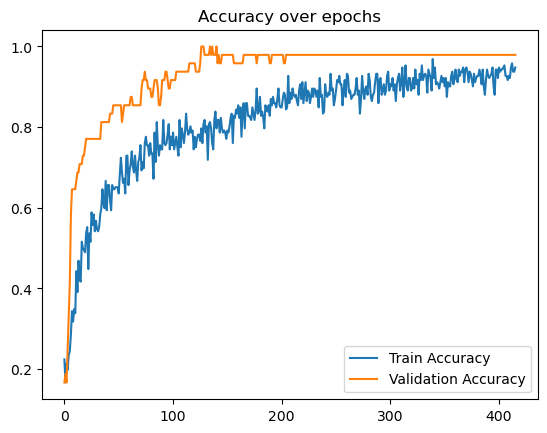

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

file_path = 'Star_6_class.csv'
df = pd.read_csv(file_path)

df['Star color'] = LabelEncoder().fit_transform(df['Star color'])
df['Spectral Class'] = LabelEncoder().fit_transform(df['Spectral Class'])

X = df.drop(columns=['Star type'])
y = df['Star type']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_encoded = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=0
)

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()
